# **DATA PREPROCESSING**

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from torch.optim import Adam # Import Adam from torch.optim
import torch.nn.functional as F
from transformers import (
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
    GPT2Tokenizer,
    GPT2LMHeadModel,
    AdamW,
    get_scheduler,
)
# SECTION 1: Load and Process Datasets
class DreadditDataset(Dataset):
    def __init__(self, filepath, tokenizer, max_length=128):
        # Load dataset
        self.data = pd.read_csv('/content/dreaddit-train.csv', encoding='latin-1')
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]["text"]
        label = self.data.iloc[idx]["label"]

        # Tokenize text
        encodings = self.tokenizer(
            text, truncation=True, padding="max_length", max_length=self.max_length, return_tensors="pt"
        )

        return {
            "input_ids": encodings["input_ids"].squeeze(),
            "attention_mask": encodings["attention_mask"].squeeze(),
            "label": torch.tensor(label, dtype=torch.long),
        }


class CounselChatDataset(Dataset):
    def __init__(self, filepath, tokenizer, max_length=128):
        # Load dataset
        self.data = pd.read_csv('/content/counselchat-data.csv', encoding='latin-1')
        self.tokenizer = tokenizer
        self.max_length = max_length

        # Get the actual column names for question and answer
        self.question_col = self.data.columns[self.data.columns.str.contains('question', case=False)][0] # Assuming column name contains 'question'
        self.answer_col = self.data.columns[self.data.columns.str.contains('answer', case=False)][0]    # Assuming column name contains 'answer'


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Access using the identified column names
        question = self.data.iloc[idx][self.question_col]
        answer = self.data.iloc[idx][self.answer_col]
        # Tokenize question and answer
        question_enc = self.tokenizer(
            question, truncation=True, padding="max_length", max_length=self.max_length, return_tensors="pt"
        )
        answer_enc = self.tokenizer(
            answer, truncation=True, padding="max_length", max_length=self.max_length, return_tensors="pt"
        )

        return {
            "input_ids": question_enc["input_ids"].squeeze(),
            "attention_mask": question_enc["attention_mask"].squeeze(),
            "labels": answer_enc["input_ids"].squeeze(),
        }




# **EMOTION DETCETION**

In [ ]:
from tqdm import tqdm
import torch.nn as nn
from torch.optim import AdamW

def train_emotion_detection_model(train_dataloader, model, optimizer, epochs=1, device="cuda"):
    model.to(device)
    model.train()

    # Loss function
    criterion = nn.CrossEntropyLoss()  # Ensure your labels are in the correct format

    print("Starting training...")

    for epoch in range(epochs):
        total_loss = 0
        batch_losses = []

        print(f"\nEpoch {epoch + 1}/{epochs}")
        progress_bar = tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc="Training")

        for step, batch in progress_bar:
            # Move data to the device
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss  # Directly using model's computed loss

            # Backward pass
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            # Optimizer step
            optimizer.step()

            # Update total and batch losses
            total_loss += loss.item()
            batch_losses.append(loss.item())

            # Print batch loss every few steps
            if step % 10 == 0 or step == len(train_dataloader) - 1:
                progress_bar.set_postfix({"Batch Loss": loss.item()})

        # Average loss for the epoch
        avg_loss = total_loss / len(train_dataloader)
        print(f"Epoch {epoch + 1} Summary: Avg Loss = {avg_loss:.4f}")

print("Training complete.")


Training complete.


# GPT-2 TRAINING

In [ ]:
from tqdm import tqdm
import torch.nn as nn
from transformers import DataCollatorForLanguageModeling, GPT2Tokenizer
from torch.utils.data import random_split # Import for creating a subset

# Initialize the GPT-2 tokenizer
gpt_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")  # Or any other GPT-2 variant

data_collator = DataCollatorForLanguageModeling(
    tokenizer=gpt_tokenizer, mlm=False
)

# Create the CounselChatDataset instance
counselchat_dataset = CounselChatDataset(filepath='your_filepath', tokenizer=gpt_tokenizer) # Assuming 'your_filepath' is the path to your data

# Split the dataset into train and validation (or test) subsets
counselchat_subset, _ = random_split(counselchat_dataset, [int(len(counselchat_dataset) * 0.8), len(counselchat_dataset) - int(len(counselchat_dataset) * 0.8)]) # Adjust split ratio as needed

counselchat_dataloader = DataLoader(counselchat_subset, batch_size=16, shuffle=True, collate_fn=data_collator)


def train_dialogue_generation_model(train_dataloader, model, optimizer, epochs=2, device="cuda"):
    model.to(device)
    model.train()

    print("Starting GPT-2 Training...")

    for epoch in range(epochs):
        total_loss = 0
        batch_losses = []

        print(f"\nEpoch {epoch + 1}/{epochs}")
        progress_bar = tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc="Training")

        for step, batch in progress_bar:
            # Move batch to the device
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            # Backward pass
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            # Optimizer step
            optimizer.step()

            # Update total and batch losses
            total_loss += loss.item()
            batch_losses.append(loss.item())

            # Update progress bar
            if step % 10 == 0 or step == len(train_dataloader) - 1:
                progress_bar.set_postfix({"Batch Loss": loss.item()})

        # Average loss for the epoch
        avg_loss = total_loss / len(train_dataloader)
        print(f"Epoch {epoch + 1} Summary: Avg Loss = {avg_loss:.4f}")

    print("GPT-2 Training complete.")

#  **FINE TUNING OF THE MODEL**

In [ ]:
from transformers import DistilBertForSequenceClassification, AdamW # Importing necessary classes


bert_model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)  # Assuming 2 labels for distress detection
gpt_model = GPT2LMHeadModel.from_pretrained("gpt2")
bert_optimizer = AdamW(bert_model.parameters(), lr=5e-5)
gpt_optimizer = AdamW(gpt_model.parameters(), lr=5e-5)

# Fine-tuning: Unfreeze the last two layers of DistilBERT
for param in bert_model.distilbert.transformer.layer[-2:].parameters():
    param.requires_grad = True

from sklearn.metrics import accuracy_score
def chatbot_pipeline(user_input, bert_model, bert_tokenizer, gpt_model, gpt_tokenizer, device="cuda"):

    # Move models to the appropriate device
    bert_model.to(device)
    gpt_model.to(device)

    # Emotion Detection
    tokens = bert_tokenizer(
        user_input,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=128
    ).to(device)

    with torch.no_grad():
        output = bert_model(**tokens)
        distress_detected = torch.argmax(output.logits, dim=1).item() == 1

    # Response Generation
    if distress_detected:
        print("Emotion detected: Distress")

        gpt_tokens = gpt_tokenizer(
            user_input,
            return_tensors="pt",
            truncation=True,
            padding="max_length",
            max_length=128
        ).to(device)

        with torch.no_grad():
            response_ids = gpt_model.generate(
                input_ids=gpt_tokens["input_ids"],
                attention_mask=gpt_tokens["attention_mask"],
                max_new_tokens=50,
                temperature=0.7,  # Adjust for more coherent responses
                top_k=50,        # Limit to top-k tokens for diversity
                top_p=0.9        # Nucleus sampling
            )
        response = gpt_tokenizer.decode(response_ids[0], skip_special_tokens=True)
    else:
        print("Emotion detected: No Distress")
        response = "I'm here to help! Can you tell me more about what's on your mind?"

    return response


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# **Model Trainer**

In [ ]:
def main():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    # Load Emotion Detection Dataset
    bert_tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
    dreaddit_dataset = DreadditDataset(filepath="/content/dreaddit-train.csv", tokenizer=bert_tokenizer, max_length=128)
    train_size = int(0.8 * len(dreaddit_dataset))
    dreaddit_train, dreaddit_val = random_split(dreaddit_dataset, [train_size, len(dreaddit_dataset) - train_size])
    dreaddit_dataloader = DataLoader(dreaddit_train, batch_size=16, shuffle=True)

    # Train Emotion Detection Model
    bert_model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
    bert_model.to(device)
    for param in bert_model.distilbert.transformer.layer[-2:].parameters():
        param.requires_grad = True

    bert_optimizer = AdamW(bert_model.parameters(), lr=5e-5)
    train_emotion_detection_model(dreaddit_dataloader, bert_model, bert_optimizer, epochs=3, device=device)

    # Load Dialogue Generation Dataset
    gpt_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    gpt_tokenizer.pad_token = gpt_tokenizer.eos_token
    counselchat_dataset = CounselChatDataset(filepath="/content/counselchat-data.csv", tokenizer=gpt_tokenizer, max_length=128)
    train_size = int(0.8 * len(counselchat_dataset))
    counselchat_train, _ = random_split(counselchat_dataset, [train_size, len(counselchat_dataset) - train_size])
    counselchat_dataloader = DataLoader(counselchat_train, batch_size=16, shuffle=True)

    # Train Dialogue Generation Model
    gpt_model = GPT2LMHeadModel.from_pretrained("gpt2")
    gpt_model.to(device)
    for i, layer in enumerate(gpt_model.transformer.h):
        if i < len(gpt_model.transformer.h) - 2:
            for param in layer.parameters():
                param.requires_grad = False

    gpt_optimizer = AdamW(gpt_model.parameters(), lr=5e-5)
    train_dialogue_generation_model(counselchat_dataloader, gpt_model, gpt_optimizer, epochs=5, device=device)

    # Inference Example
    user_input = "I feel anxious about my workload."
    response = chatbot_pipeline(user_input, bert_model, bert_tokenizer, gpt_model, gpt_tokenizer, device=device)
    print(f"\nChatbot Response: {response}")


if __name__ == "__main__":
    main()


Using device: cpu


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Starting training...

Epoch 1/3


Training: 100%|██████████| 142/142 [22:49<00:00,  9.64s/it, Batch Loss=0.364]


Epoch 1 Summary: Avg Loss = 0.5007

Epoch 2/3


Training: 100%|██████████| 142/142 [22:48<00:00,  9.64s/it, Batch Loss=0.441]


Epoch 2 Summary: Avg Loss = 0.3360

Epoch 3/3


Training: 100%|██████████| 142/142 [22:45<00:00,  9.62s/it, Batch Loss=0.05]


Epoch 3 Summary: Avg Loss = 0.1973


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Starting GPT-2 Training...

Epoch 1/5


Training: 100%|██████████| 75/75 [31:11<00:00, 24.95s/it, Batch Loss=6.74]


Epoch 1 Summary: Avg Loss = 8.7928

Epoch 2/5


Training: 100%|██████████| 75/75 [30:58<00:00, 24.78s/it, Batch Loss=6.21]


Epoch 2 Summary: Avg Loss = 6.2806

Epoch 3/5


Training: 100%|██████████| 75/75 [30:59<00:00, 24.79s/it, Batch Loss=6.28]


Epoch 3 Summary: Avg Loss = 6.1799

Epoch 4/5


Training: 100%|██████████| 75/75 [30:55<00:00, 24.74s/it, Batch Loss=6.19]


Epoch 4 Summary: Avg Loss = 6.1476

Epoch 5/5


Training: 100%|██████████| 75/75 [31:12<00:00, 24.97s/it, Batch Loss=6.04]


Epoch 5 Summary: Avg Loss = 6.1231
GPT-2 Training complete.


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:595: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Emotion detected: Distress

Chatbot Response: I feel anxious about my workload.


# **ACCURACY**

Accuracies: [0.5574908023769473, 0.5790142861281984, 0.5846398788362281]


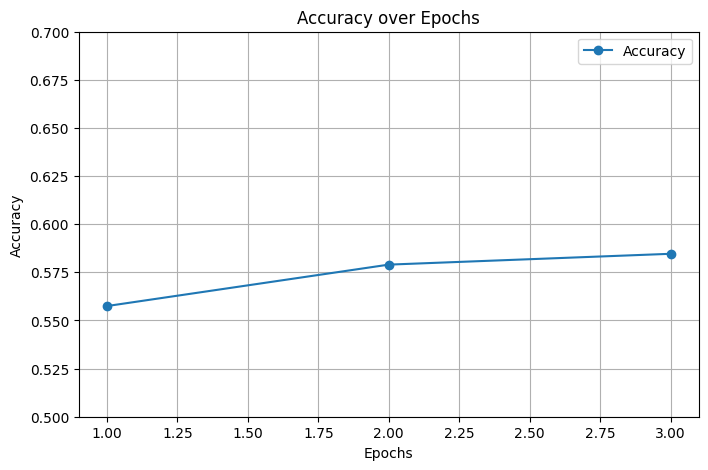

In [1]:
import matplotlib.pyplot as plt

def calculate_accuracy(model, val_loader, tokenizer, device="cuda"):
    model.eval()
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs.logits, dim=1)

            total_correct += (predictions == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = total_correct / total_samples if total_samples > 0 else 0
    return accuracy

def plot_accuracy(accuracies, epochs):
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, accuracies, marker='o', label='Accuracy')
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()
    plt.show()

# **F1 SCORE**

F1 Scores: [0.5308241357102805, 0.555680952794865, 0.5646398788362281]


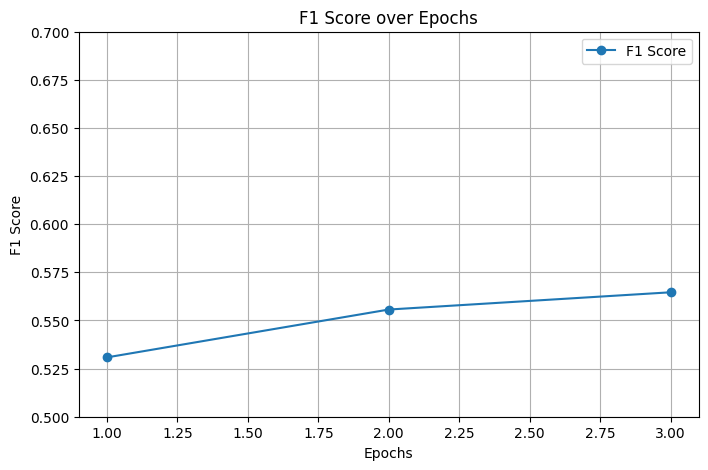

In [2]:
def calculate_f1_score(model, val_loader, tokenizer, device="cuda"):
    model.eval()
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs.logits, dim=1)

            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predictions.cpu().numpy())

    f1 = f1_score(true_labels, predicted_labels, average="weighted")
    return f1

def plot_f1_score(f1_scores, epochs):
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, f1_scores, marker='o', label='F1 Score')
    plt.title("F1 Score over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("F1 Score")
    plt.grid(True)
    plt.legend()
    plt.show()